In [105]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df_2022 = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [3]:
#for x in df_2022.columns:
    #print(x)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


I want to explore the various metrics to identify team scheme. To do so, I will start by isolating the play-by-play data into solely offensive plays.

In [32]:
df_2022.play_type.value_counts()

pass           20393
run            15037
no_play         4563
kickoff         2835
punt            2294
extra_point     1253
field_goal      1105
qb_kneel         442
qb_spike          63
Name: play_type, dtype: int64

We see that the 'play_type' column will help us narrow down our dataset. I will choose solely pass and run plays. Pass plays include sacks, and run plays include QB scrambles. I am choosing to exclude QB Kneel and QB Spike despite them being offensive plays - this will cause some discrepancy with official statistics that counts the two as rush and pass attempts respectively. No Play stands for timeouts and penalties.

In [80]:
offense_plays = df_2022.loc[(df_2022['season_type']=='REG')&
                            ((df_2022['play_type']=='run') | (df_2022['play_type']=='pass'))]

In [81]:
offense_plays = offense_plays[['play_id', 'game_id','qtr','quarter_seconds_remaining', 'posteam', 'defteam', 'play_type', 
                               'sack', 'qb_dropback','qb_scramble','complete_pass',
                               'down', 'yardline_100', 'ydstogo',
                               'passing_yards', 'rushing_yards', 'receiving_yards',
                               'pass_touchdown', 'rush_touchdown', 'score_differential','wp', 'def_wp']]

It is key to note that the 'pass' play_type includes pass attempts and sacks. However, to understand scheme, I have included the binary variable 'qb_dropback', which equals 1.0 if the QB dropped back to pass, took a sack, or scrambled.

In [82]:
offense_plays['pass_play_call'] = (offense_plays['qb_dropback'] == 1.0)
offense_plays['pass_attempt'] = offense_plays['pass_play_call'] - offense_plays['sack'] - offense_plays['qb_scramble']
offense_plays['rush_attempt'] = (offense_plays['play_type'] == 'run').astype(int)
offense_plays['run_play_call'] = offense_plays['rush_attempt'] - offense_plays['qb_scramble']
offense_plays.groupby('posteam').agg(pass_attempts=('pass_attempt', 'sum')).sort_values(by='pass_attempts')

,pass_attempts
posteam,
CHI,381.0
ATL,413.0
CAR,455.0
TEN,456.0
BAL,484.0
NO,512.0
SF,512.0
NYG,520.0
LA,529.0


There is a very slight question about inaccurary, but not one that makes me worried about the data, when compared to official statistics from nfl.com. The largest discrepancy is only 4 pass attempts, so the percentages/ratios I calculate later won't be wrong to the point where the exploration is affected.

Note that I also separated rush attempts and run play calls by taking out qb scrambles. I will have to decide how to bring scramble numbers into any ratio I calculate. For now, let's just take an early look at all pass play calls (incl. scrambles) and run play calls (no scrambles).

In [83]:
scheme = offense_plays.groupby(['posteam']).agg(pass_play_calls=('pass_play_call', 'sum'),
                                                run_play_calls=('run_play_call', 'sum'))
                                                
scheme['offensive_plays'] = scheme['pass_play_calls'] + scheme['run_play_calls']
scheme['pass_ratio'] = scheme['pass_play_calls']/scheme['offensive_plays']
scheme.sort_values(by='pass_ratio', ascending=False)

,pass_play_calls,run_play_calls,offensive_plays,pass_ratio
posteam,,,,
TB,780,366.0,1146.0,0.680628
LAC,773,364.0,1137.0,0.679859
KC,726,359.0,1085.0,0.669124
CIN,685,349.0,1034.0,0.662476
MIN,735,379.0,1114.0,0.659785
ARI,753,389.0,1142.0,0.659370
NYJ,688,375.0,1063.0,0.647225
BUF,658,360.0,1018.0,0.646365
MIA,638,357.0,995.0,0.641206


These results look pretty accurate! The NFL was led by the Buccaneers in pass play calls, which is understandable with Tom Brady, but also with their depleted O-Line and horrendous run game. Chargers, Chiefs, Bengals, and Vikings in the top 5 all make sense from a stylistic point of view. Cardinals also had a pass-heavy, air raid scheme, but them, along with the Jets and Houston, likely saw their pass attempts significantly boosted due to how weak the team was on the field. The latter two would have been forced into passing plays more often than the average team. We will need to extract and look at neutral down passing situations to take away game state.

On the other end of the table, it makes sense that Atlanta and Chicago called the highest percentage of run plays. I would actually expect Chicago to be the bottom team if we worked QB scrambles in there, although Marcus Mariota would have contributed on the ground as well. Carolina, SF, Tennesee, and Dallas also have run-heavy schemes. It is surprising that three extremely poor teams in the Falcons, Bears, and Panthers leaned heavily on the run, despite theoretically being behind more than the average team? We will have to explore further, but the first look at this data seems quite accurate.

Let's take a look at the play call ratio in neutral game scripts. I am going to call neutral gamescripts situations where wp is at least 25%, but no more than 75%. This "middle 50%" should provide a good sample for neutral states.

In [84]:
neutral_offense_plays = offense_plays.loc[(offense_plays['wp']>=0.25)&(offense_plays['wp']<=0.75)]
len(neutral_offense_plays)

19157

I do want to exclude two other situations - game states where clock management comes into play. I am going to remove the two-minute warning in each half from the play sample.

In [85]:
neutral_offense_plays = neutral_offense_plays.loc[~((neutral_offense_plays['qtr']==2)
                                                    &(neutral_offense_plays['quarter_seconds_remaining']<=120))]
neutral_offense_plays[neutral_offense_plays['qtr']==2]['quarter_seconds_remaining'].sort_values()

18664    121.0
15511    121.0
10331    121.0
2790     121.0
45638    121.0
         ...  
27298    900.0
27662    900.0
27835    900.0
26740    900.0
42       900.0
Name: quarter_seconds_remaining, Length: 4460, dtype: float32

In [86]:
neutral_offense_plays = neutral_offense_plays.loc[~((neutral_offense_plays['qtr']==4)
                                                    &(neutral_offense_plays['quarter_seconds_remaining']<=120))]
neutral_offense_plays[neutral_offense_plays['qtr']==4]['quarter_seconds_remaining'].sort_values()

10424    121.0
29490    121.0
41720    121.0
9199     121.0
37648    121.0
         ...  
45525    900.0
17293    900.0
15361    900.0
6134     900.0
38227    900.0
Name: quarter_seconds_remaining, Length: 2021, dtype: float32

Just had to make sure my negative operators were working correctly, ya know. Just to make sure there isn't any OT strangeness, I am going to remove those plays as well.

In [87]:
neutral_offense_plays = neutral_offense_plays.loc[neutral_offense_plays['qtr']!=5]
len(neutral_offense_plays)

17115

Great, a sample of 17k+ plays - this should do nicely. By isolating out scenarios were one team is significantly favored, or there are clock-related strategic constraints, we can understand a team's scheme fit more clearly.

In [88]:
neutral_scheme = neutral_offense_plays.groupby(['posteam']).agg(pass_play_calls=('pass_play_call', 'sum'),
                                                run_play_calls=('run_play_call', 'sum'))
                                                
neutral_scheme['offensive_plays'] = neutral_scheme['pass_play_calls'] + neutral_scheme['run_play_calls']
neutral_scheme['pass_ratio'] = neutral_scheme['pass_play_calls']/neutral_scheme['offensive_plays']
neutral_scheme.sort_values(by='pass_ratio', ascending=False)

,pass_play_calls,run_play_calls,offensive_plays,pass_ratio
posteam,,,,
CIN,310,132.0,442.0,0.701357
KC,354,173.0,527.0,0.671727
LAC,385,211.0,596.0,0.645973
BUF,375,206.0,581.0,0.645439
MIN,307,175.0,482.0,0.636929
SEA,358,208.0,566.0,0.632509
MIA,314,200.0,514.0,0.610895
PHI,300,194.0,494.0,0.607287
ARI,328,214.0,542.0,0.605166


Much more interesting results here. The top 4 look familiar and seem to make sense, but I am shocked that Seattle and especially New England called a pass 60%+ of the time in neutral states. However, it is important to note that their percentages barely shifted - other teams just ran more heavily in neutral states, such as Houston, whose pass ratio dropped from 63.4% to 53.6%. It is the perception of those teams (Seahawks and Patriots) as run-heavy which stands out more to me, as seemingly disproven by this data.

In [89]:
ne = offense_plays.loc[offense_plays['posteam']=='NE'].groupby(['posteam', 'play_type']).agg(pass_play_calls=('pass_play_call', 'sum'),
                                                run_play_calls=('run_play_call', 'sum'))
ne

pass_play_calls  run_play_calls
posteam play_type                                 
NE      pass                   583             0.0
        run                     21           382.0

I'm honestly a little baffled by the Patriots ratio. I'm going to dig into the original data. In the total play-by-play data grouped above, we count 382 run play calls. This does exclude scrambles and kneels, but the NFL data give the Patriots 425 rush attempts? A discrepancy of 43 seems excessive (Data sourced: https://www.nfl.com/stats/team-stats/offense/rushing/2022/reg/all).

In [90]:
ne_plays = df_2022.loc[(df_2022['season_type']=='REG')& (df_2022['posteam']=='NE') &
                            ((df_2022['play_type']=='run') | (df_2022['play_type']=='pass') |(df_2022['play_type']=='qb_kneel'))]
ne_plays['pass_attempt'] = (ne_plays['play_type'] == 'pass').astype(int) - ne_plays['sack']
ne_plays['rush_attempt'] = (ne_plays['play_type'] == 'run').astype(int)
ne_plays.groupby('posteam').agg({'pass_attempt':'sum',
                                 'rush_attempt':'sum',
                                 'qb_kneel':'sum'})

/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_70506/1289911311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ne_plays['pass_attempt'] = (ne_plays['play_type'] == 'pass').astype(int) - ne_plays['sack']
/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_70506/1289911311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ne_plays['rush_attempt'] = (ne_plays['play_type'] == 'run').astype(int)


,pass_attempt,rush_attempt,qb_kneel
posteam,,,
NE,542.0,403,22.0


Oh. Never mind then. 21 scrambles in 17 games sure, but 22 kneels? That's a lot of kneeling for Mac Jones/Bailey Zappe. But there's our 425 rush attempts. I'm going to do the same for Seattle to make sure:

In [91]:
sea_plays = df_2022.loc[(df_2022['season_type']=='REG')& (df_2022['posteam']=='SEA') &
                            ((df_2022['play_type']=='run') | (df_2022['play_type']=='pass') |(df_2022['play_type']=='qb_kneel'))]
sea_plays['pass_attempt'] = (sea_plays['play_type'] == 'pass').astype(int) - sea_plays['sack']
sea_plays['rush_attempt'] = (sea_plays['play_type'] == 'run').astype(int)
sea_plays.groupby('posteam').agg({'pass_attempt':'sum',
                                 'rush_attempt':'sum',
                                 'qb_kneel':'sum'})

/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_70506/2227281995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sea_plays['pass_attempt'] = (sea_plays['play_type'] == 'pass').astype(int) - sea_plays['sack']
/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_70506/2227281995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sea_plays['rush_attempt'] = (sea_plays['play_type'] == 'run').astype(int)


,pass_attempt,rush_attempt,qb_kneel
posteam,,,
SEA,574.0,413,12.0


Spot on, 425 rush attempts for the Seahawks as well. 33 scrambles for Geno Smith (we saw 380 run play calls). Okay, I am reassured about the data. I am still undecided about how to incorporate scrambles, but I want to purely look at play calls by the coaching staff in this experiment - in this sense, every scramble is born out of a pass play call.

With this side exploration completed, I feel much more reassured in the data. Let's get back to it. We have the ratios in neutral gamestates, but let's drill down even further to early downs.

In [93]:
early_down_neutral_offense_plays = neutral_offense_plays.loc[neutral_offense_plays['down']<=2.0]
len(early_down_neutral_offense_plays)

13256

A sample of 13k now. Removing 3rd down should really highlight which teams lean on the pass, by removing plays where teams need to pass out of necessity (such as 3rd & long).

In [95]:
early_down_neutral_scheme = early_down_neutral_offense_plays.groupby(['posteam']).agg(pass_play_calls=('pass_play_call', 'sum'),
                                                run_play_calls=('run_play_call', 'sum'))
                                                
early_down_neutral_scheme['offensive_plays'] = early_down_neutral_scheme['pass_play_calls'] + early_down_neutral_scheme['run_play_calls']
early_down_neutral_scheme['pass_ratio'] = early_down_neutral_scheme['pass_play_calls']/early_down_neutral_scheme['offensive_plays']
early_down_neutral_scheme.sort_values(by='pass_ratio', ascending=False)

,pass_play_calls,run_play_calls,offensive_plays,pass_ratio
posteam,,,,
CIN,224,122.0,346.0,0.647399
KC,270,159.0,429.0,0.629371
LAC,273,179.0,452.0,0.603982
BUF,279,185.0,464.0,0.601293
PHI,222,159.0,381.0,0.582677
SEA,260,188.0,448.0,0.580357
MIN,205,167.0,372.0,0.551075
ARI,227,186.0,413.0,0.549637
MIA,221,184.0,405.0,0.545679


We have a new run-rate leader now, in the Washington Commanders. They only called passing plays on 40.2% of early downs in neutral game states. The picture here is starting to clear up, especially when you look at the names at the bottom of the table: Commanders, Falcons, Saints, Chicago, Titans, Panthers...these teams do have a strong association with the run.

I like the route we have taken here with neutral game states, then drilling even further into early downs in neutral states. These plays should tell us, when un-impacted by scoreline, clock management, time, or down conversion, which teams prefer to pass the ball, as dictated by scheme.

I am going to set this aside now, and go a level up back to neutral game states. Now, I want to zoom in on plays in the red-zone, or within the opposition 20. I want to see how teams attack scoring positions.

In [97]:
red_zone_neutral_offense_plays = neutral_offense_plays.loc[neutral_offense_plays['yardline_100']<=20.0]
len(red_zone_neutral_offense_plays)

2302

Only 2,300 plays total. I may choose to remove the WP filter (for neutral game state).

In [98]:
rz_neutral_scheme = red_zone_neutral_offense_plays.groupby(['posteam']).agg(pass_play_calls=('pass_play_call', 'sum'),
                                                run_play_calls=('run_play_call', 'sum'))
                                                
rz_neutral_scheme['offensive_plays'] = rz_neutral_scheme['pass_play_calls'] + rz_neutral_scheme['run_play_calls']
rz_neutral_scheme['pass_ratio'] = rz_neutral_scheme['pass_play_calls']/rz_neutral_scheme['offensive_plays']
rz_neutral_scheme.sort_values(by='pass_ratio', ascending=False)

,pass_play_calls,run_play_calls,offensive_plays,pass_ratio
posteam,,,,
MIN,50,21.0,71.0,0.704225
CIN,46,20.0,66.0,0.696970
TB,49,28.0,77.0,0.636364
KC,57,33.0,90.0,0.633333
LA,41,24.0,65.0,0.630769
BAL,44,28.0,72.0,0.611111
GB,51,33.0,84.0,0.607143
SEA,43,35.0,78.0,0.551282
NE,38,31.0,69.0,0.550725


Some surprising data points here. The biggest flip in scheme is with the Eagles, who had an early down, neutral game state pass ratio of 58.2% - but this drops all the way to 36.7% in the red zone. With a mobile weapon like Jalen Hurts, and the strength of their QB Sneak, this does make sense.

Another big change is the Vikings going from 55.1% pass ratio in early downs, but jumping to 70.4% in the red zone. This is likely a product of the Kevin O'Connell offense.

While the earlier two seem explainable, I am surprised with the Ravens favoring the pass in the red zone, increasing from 52.5% overall on early downs to 61.1% in the red zone. Under Greg Roman, they have heavily favored the run, and they have an elite running QB in Lamar Jackson.

Poor Carolina had only 44 neutral game state plays in the red zone.

In [102]:
ed_temp = early_down_neutral_scheme.reset_index()[['posteam', 'pass_ratio']]
rz_temp = rz_neutral_scheme.reset_index()[['posteam', 'pass_ratio']]
ed_temp = ed_temp.rename(columns={'pass_ratio':'early_down_pass_ratio'})
rz_temp = rz_temp.rename(columns={'pass_ratio':'red_zone_pass_ratio'})
comb = pd.merge(ed_temp,rz_temp,on='posteam')
comb

,posteam,early_down_pass_ratio,red_zone_pass_ratio
0,ARI,0.549637,0.481013
1,ATL,0.412736,0.384615
2,BAL,0.525424,0.611111
3,BUF,0.601293,0.549451
4,CAR,0.447887,0.363636
5,CHI,0.422434,0.405405
6,CIN,0.647399,0.696970
7,CLE,0.491031,0.500000
8,DAL,0.475410,0.430380
9,DEN,0.500000,0.500000


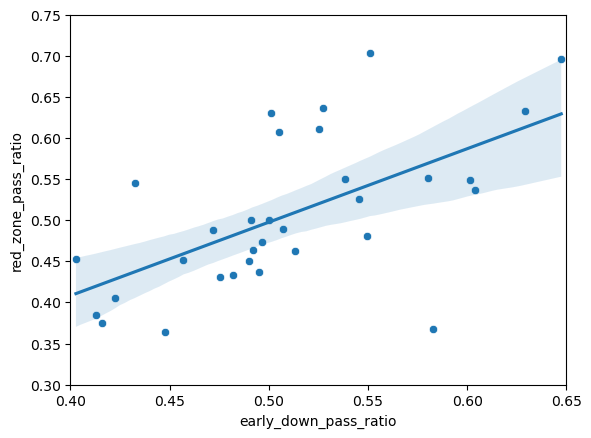

In [113]:
sns.scatterplot(data=comb,x='early_down_pass_ratio',y='red_zone_pass_ratio')
plt.xlim(0.4, 0.65)
plt.ylim(0.3,0.75)
sns.regplot(data=comb,x='early_down_pass_ratio',y='red_zone_pass_ratio', scatter=False)
plt.show()

The Eagles really do stand out here, towards the bottom right.

I'm going to look at these metrics from a different angle now. Our dataset has a percentage variable 'xpass', which calculates the probability with which a team will drop back to pass.

In [124]:
pass_call_vs_expected = df_2022.loc[(df_2022['season_type']=='REG')&
                            ((df_2022['play_type']=='run') | (df_2022['play_type']=='pass'))
                                    , ['play_id', 'game_id', 'posteam', 'xpass', 'qb_dropback', 
                                       'wp', 'qtr', 'quarter_seconds_remaining', 'down', 'yardline_100']]
dropback_prob_grouper = pass_call_vs_expected.groupby('posteam').agg({'qb_dropback':'sum', 'xpass':'sum'})
dropback_prob_grouper['season_pass_oe'] = dropback_prob_grouper['qb_dropback'] - dropback_prob_grouper['xpass']
dropback_prob_grouper.sort_values(by='season_pass_oe', ascending=False)

,qb_dropback,xpass,season_pass_oe
posteam,,,
KC,726.0,605.378235,120.621765
CIN,685.0,600.923889,84.076111
BUF,658.0,594.853760,63.146240
TB,780.0,725.503479,54.496521
LAC,773.0,721.066040,51.933960
MIN,735.0,703.029968,31.970032
MIA,638.0,616.233093,21.766907
SEA,653.0,634.636292,18.363708
JAX,652.0,645.390015,6.609985


Unsurprisingly, the results here ended up looking very similar to the other metrics we've calculated. It is surprising to me that most teams have negative season_pass_oe, perhaps indicating that teams are still too conversative in some situations. 

There is more analysis to be done here definitely, but I believe that I have a good understanding of team scheme from my exploration.

Thanks for reading!